In [269]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, BatchNormalization, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.models import Model
"""from tensorflow.keras.preprocessing.image import ImageDataGenerator"""
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
import os
import shutil
import sys
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
from random import randint
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
import random as rn
%matplotlib inline

In [270]:
import os
os.environ['PYTHONHASHEED']='0'

In [271]:
np.random.seed(1234)

In [272]:
rn.seed(4321)

In [273]:
tf.random.set_seed(1324)

In [274]:
'''from keras import backend as K
sess=tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)'''

'from keras import backend as K\nsess=tf.Session(graph=tf.get_default_graph(), config=session_conf)\nK.set_session(sess)'

In [275]:
#einfach um zu schauen, dass tensorflow das GPU identifizieren kann - wenn 1, dann wurde es identifiziert
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(physical_devices)) # print out number of GPUs available
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Num GPUs Available:  1


In [276]:
#Organize data into train, valid, test dirs
os.chdir(r"C:\Users\ammasi\Desktop\data\haut")
if os.path.isdir('train/0/') is False: 
    os.mkdir('train')
    os.mkdir('valid')
    os.mkdir('test')

    for i in range(0, 2):
        shutil.move(f'{i}', 'train')
        os.mkdir(f'valid/{i}')
        os.mkdir(f'test/{i}')

        valid_samples = random.sample(os.listdir(f'train/{i}'), 200)
        for j in valid_samples:
            shutil.move(f'train/{i}/{j}', f'valid/{i}')

        test_samples = random.sample(os.listdir(f'train/{i}'), 100)
        for k in test_samples:
            shutil.move(f'train/{i}/{k}', f'test/{i}')
os.chdir('../..')

In [277]:
train_path=r"C:\Users\ammasi\Desktop\data\haut\train"
valid_path=r"C:\Users\ammasi\Desktop\data\haut\valid"
test_path=r"C:\Users\ammasi\Desktop\data\haut\test"

In [278]:
'''train_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches=ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10)'''

train_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=train_path, target_size=(224,224), batch_size=10)
valid_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=valid_path, target_size=(224,224), batch_size=10)
test_batches = ImageDataGenerator(preprocessing_function=tf.keras.applications.mobilenet.preprocess_input).flow_from_directory(class_mode='categorical',
    directory=test_path, target_size=(224,224), batch_size=10, shuffle=False)

Found 2697 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [279]:
assert train_batches.n == 2697
assert valid_batches.n == 400
assert test_batches.n == 200
assert train_batches.num_classes == valid_batches.num_classes==test_batches.num_classes==2

In [280]:
surface=tf.keras.applications.mobilenet.MobileNet()

In [281]:
surface.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32

In [282]:
'''params = count_params(mobile)
assert params['non-trainable_params'] == 21888
assert params['trainable_params'] == 4231976'''

"params = count_params(mobile)\nassert params['non-trainable_params'] == 21888\nassert params['trainable_params'] == 4231976"

## Modify Model

In [283]:
x = surface.layers[-6].output

In [284]:
output = Dense(units=2, activation='sigmoid')(x)

In [285]:
model = Model(inputs=surface.input, outputs=output)

In [286]:
for layer in model.layers[:-23]:
    layer.trainable = False

In [287]:
model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 112, 112, 32)     

In [288]:
'''loss = tf.keras.losses.SparseCategoricalCrossentropy()
optim = keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]

model.compile(loss=loss, optimizer=optim, metrics=metrics)'''

'loss = tf.keras.losses.SparseCategoricalCrossentropy()\noptim = keras.optimizers.Adam(lr=0.001)\nmetrics = ["accuracy"]\n\nmodel.compile(loss=loss, optimizer=optim, metrics=metrics)'

In [289]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'categorical_crossentropy', metrics=['accuracy'])

In [290]:
model.fit(x=train_batches, validation_data=valid_batches, epochs=15, verbose=2)

Epoch 1/15
270/270 - 8s - loss: 0.3972 - accuracy: 0.8109 - val_loss: 0.4498 - val_accuracy: 0.8150
Epoch 2/15
270/270 - 7s - loss: 0.2520 - accuracy: 0.8802 - val_loss: 0.3395 - val_accuracy: 0.8250
Epoch 3/15
270/270 - 9s - loss: 0.2047 - accuracy: 0.9043 - val_loss: 0.3575 - val_accuracy: 0.8550
Epoch 4/15
270/270 - 8s - loss: 0.1570 - accuracy: 0.9251 - val_loss: 0.2944 - val_accuracy: 0.8900
Epoch 5/15
270/270 - 9s - loss: 0.1135 - accuracy: 0.9544 - val_loss: 0.6164 - val_accuracy: 0.7700
Epoch 6/15
270/270 - 8s - loss: 0.1021 - accuracy: 0.9600 - val_loss: 0.4663 - val_accuracy: 0.8350
Epoch 7/15
270/270 - 8s - loss: 0.0815 - accuracy: 0.9685 - val_loss: 0.3116 - val_accuracy: 0.8800
Epoch 8/15
270/270 - 8s - loss: 0.0571 - accuracy: 0.9811 - val_loss: 0.3178 - val_accuracy: 0.8875
Epoch 9/15
270/270 - 8s - loss: 0.0466 - accuracy: 0.9826 - val_loss: 0.3531 - val_accuracy: 0.9025
Epoch 10/15
270/270 - 8s - loss: 0.0443 - accuracy: 0.9852 - val_loss: 0.5170 - val_accuracy: 0.8600

In [291]:
test_labels = test_batches.classes

In [292]:
predictions = model.predict(x=test_batches, steps=len(test_batches), verbose=0)

In [293]:
cm = confusion_matrix(y_true=test_labels, y_pred=predictions.argmax(axis=1))

In [294]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [295]:
test_batches.class_indices

{'0': 0, '1': 1}

Confusion matrix, without normalization
[[68 32]
 [ 4 96]]


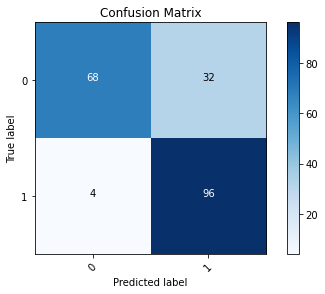

In [296]:
cm_plot_labels = ['0','1']
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [297]:
test_batches.class_indices

{'0': 0, '1': 1}

## VVG16

In [298]:
train_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), classes=["0", "1"], batch_size=10)
valid_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), classes=["0", "1"], batch_size=10)
test_batches_vgg16=ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg16.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), classes=["0", "1"], batch_size=10, shuffle=False)

Found 2697 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [299]:
assert train_batches_vgg16.n == 2697
assert valid_batches_vgg16.n == 400
assert test_batches_vgg16.n == 200 
assert train_batches_vgg16.num_classes == valid_batches_vgg16.num_classes==test_batches_vgg16.num_classes==2

In [300]:
imgs, labels = next(train_batches_vgg16)

In [301]:
model=Sequential([
      Conv2D(filters=32, kernel_size=(3,3), activation="relu", padding="same", input_shape=(224,224, 3)),
      MaxPool2D(pool_size=(2,2), strides=2),
      Conv2D(filters=64, kernel_size=(3,3), activation="relu", padding="same"),
      MaxPool2D(pool_size=(2,2), strides=2),
      Flatten(),
      Dense(units=2, activation ="softmax"),
                 ])

In [302]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 224, 224, 32)      896       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 32)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 112, 112, 64)      18496     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 200704)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 401410    
Total params: 420,802
Trainable params: 420,802
Non-trainable params: 0
________________________________________________

In [303]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss="categorical_crossentropy", metrics=["accuracy"])

In [304]:
model.fit(x=train_batches_vgg16, validation_data=valid_batches_vgg16, epochs=10, verbose=2)

Epoch 1/10
270/270 - 8s - loss: 9.1465 - accuracy: 0.7297 - val_loss: 5.3107 - val_accuracy: 0.5975
Epoch 2/10
270/270 - 8s - loss: 0.7471 - accuracy: 0.8446 - val_loss: 0.6439 - val_accuracy: 0.8175
Epoch 3/10
270/270 - 7s - loss: 0.2475 - accuracy: 0.9118 - val_loss: 0.6289 - val_accuracy: 0.8225
Epoch 4/10
270/270 - 7s - loss: 0.1092 - accuracy: 0.9600 - val_loss: 0.6191 - val_accuracy: 0.8175
Epoch 5/10
270/270 - 7s - loss: 0.0617 - accuracy: 0.9781 - val_loss: 0.6293 - val_accuracy: 0.8225
Epoch 6/10
270/270 - 7s - loss: 0.0443 - accuracy: 0.9867 - val_loss: 0.6696 - val_accuracy: 0.8275
Epoch 7/10
270/270 - 7s - loss: 0.0262 - accuracy: 0.9926 - val_loss: 0.7865 - val_accuracy: 0.8375
Epoch 8/10
270/270 - 7s - loss: 0.0087 - accuracy: 1.0000 - val_loss: 0.7013 - val_accuracy: 0.8475
Epoch 9/10
270/270 - 7s - loss: 0.0057 - accuracy: 1.0000 - val_loss: 0.6996 - val_accuracy: 0.8025
Epoch 10/10
270/270 - 7s - loss: 0.0028 - accuracy: 1.0000 - val_loss: 0.7427 - val_accuracy: 0.8125

In [305]:
predictions=model.predict(x=test_batches_vgg16, verbose=0)

In [306]:
cm=confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=np.argmax(predictions, axis=-1))

In [307]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
# https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html    

Confusion matrix, without normalization
[[83 17]
 [25 75]]


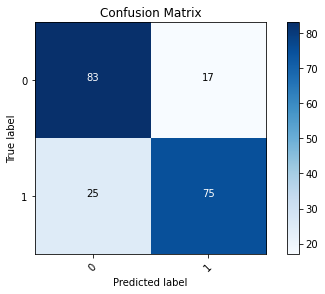

In [308]:
cm_plot_labels=["0", "1"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

## Resnet

In [309]:
train_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=train_path, target_size=(224,224), class_mode='categorical', batch_size=10)

valid_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=valid_path, target_size=(224,224), class_mode='categorical', batch_size=10)

test_batches_rn=ImageDataGenerator(preprocessing_function=tf.keras.applications.resnet.preprocess_input) \
    .flow_from_directory(directory=test_path, target_size=(224,224), class_mode='categorical', batch_size=10, shuffle=False)

Found 2697 images belonging to 2 classes.
Found 400 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


In [310]:
assert train_batches_rn.n == 2697
assert valid_batches_rn.n == 400 
assert test_batches_rn.n == 200  
assert train_batches_rn.num_classes == valid_batches_rn.num_classes==test_batches_rn.num_classes==2

In [311]:
surface=tf.keras.applications.resnet.ResNet50()

In [312]:
surface.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [313]:
model.compile(optimizer=Adam(learning_rate=0.0001), loss = 'binary_crossentropy', metrics=['accuracy'])

In [314]:
model.fit(x=train_batches_rn, validation_data=valid_batches_rn, epochs=10, verbose=2)

Epoch 1/10
270/270 - 7s - loss: 0.1884 - accuracy: 0.9540 - val_loss: 0.6510 - val_accuracy: 0.8100
Epoch 2/10
270/270 - 8s - loss: 0.0338 - accuracy: 0.9878 - val_loss: 0.7990 - val_accuracy: 0.7975
Epoch 3/10
270/270 - 8s - loss: 0.0189 - accuracy: 0.9944 - val_loss: 0.6722 - val_accuracy: 0.8275
Epoch 4/10
270/270 - 8s - loss: 0.0433 - accuracy: 0.9870 - val_loss: 1.0746 - val_accuracy: 0.7625
Epoch 5/10
270/270 - 8s - loss: 0.0403 - accuracy: 0.9885 - val_loss: 0.6721 - val_accuracy: 0.8150
Epoch 6/10
270/270 - 8s - loss: 0.0624 - accuracy: 0.9811 - val_loss: 0.7702 - val_accuracy: 0.7800
Epoch 7/10
270/270 - 8s - loss: 0.0372 - accuracy: 0.9904 - val_loss: 0.7691 - val_accuracy: 0.7900
Epoch 8/10
270/270 - 8s - loss: 0.0078 - accuracy: 0.9989 - val_loss: 0.7854 - val_accuracy: 0.8200
Epoch 9/10
270/270 - 8s - loss: 0.0015 - accuracy: 1.0000 - val_loss: 0.8378 - val_accuracy: 0.8175
Epoch 10/10
270/270 - 8s - loss: 9.2491e-04 - accuracy: 1.0000 - val_loss: 0.8539 - val_accuracy: 0.

In [315]:
predictions=model.predict(x=test_batches_rn, verbose=0)

In [316]:
cm=confusion_matrix(y_true=test_batches_vgg16.classes, y_pred=np.argmax(predictions, axis=-1))

Confusion matrix, without normalization
[[80 20]
 [20 80]]


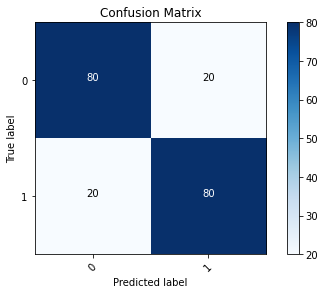

In [317]:
cm_plot_labels=["0", "1"]
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title="Confusion Matrix")

In [318]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

In [260]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.1, height_shift_range=0.1, shear_range=0.15, zoom_range=0.1, 
    channel_shift_range=10., horizontal_flip=True)

In [261]:
chosen_image = random.choice(os.listdir(r'C:\Users\ammasi\Desktop\data\haut\train\0'))

In [262]:
image_path = 'data/haut/train/0/' + chosen_image

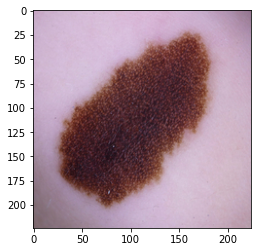

In [263]:
image = np.expand_dims(plt.imread(image_path),0)
plt.imshow(image[0])

In [264]:
aug_iter = gen.flow(image)

In [265]:
#Get 10 samples of augmented images
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]

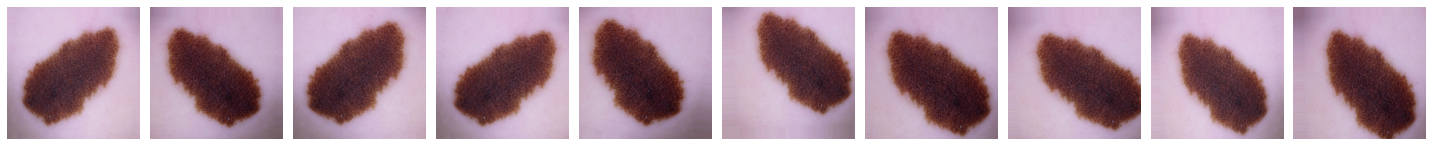

In [266]:
plotImages(aug_images)

In [267]:
aug_iter = gen.flow(image, save_to_dir='data/new', save_prefix="", save_format='jpeg')

In [268]:
save_here =r'C:\Users\ammasi\Desktop\data\new'

In [325]:
i = 0
for batch in gen.flow_from_directory(save_here, target_size=(224,224),
    class_mode='categorical', shuffle=False, batch_size=2,
    save_to_dir=path+'augmented', save_prefix='0', save_format='jpeg'):

    i += 1
    if i > 20: # save 20 images
        break  # otherwise the generator would loop indefinitely

Found 0 images belonging to 0 classes.
